In [1]:
# 1. 필수 라이브러리 설치 (약 1분 소요)
!pip install -q -U albumentations timm open_clip_torch ultralytics pycocotools

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler
from torchvision.ops import roi_align
import open_clip
import timm
import json
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageFile
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.transforms as T

# 에러 방지 설정
ImageFile.LOAD_TRUNCATED_IMAGES = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 하이퍼파라미터
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 5  # 비교 실험용 (실전엔 10~15 추천)

# 클래스 및 프롬프트 정의
UNIFIED_CLASSES = ["Person", "Bicycle", "Car", "Motorcycle", "Bus", "Truck", "Traffic Light"]
TEXT_PROMPTS = [f"a photo of a {c.lower()} on the road" for c in UNIFIED_CLASSES]

# 정규화 상수
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

print(f"✅ Setup Complete. Device: {DEVICE}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
✅ Setup Complete. Device: cuda


In [2]:
# 데이터 다운로드 함수
def download_data():
    if not os.path.exists("train2017"):
        print("⬇️ Downloading COCO Train (Fast mirror)...")
        os.system("wget -q https://s3.amazonaws.com/fast-ai-coco/train2017.zip")
        os.system("wget -q https://s3.amazonaws.com/fast-ai-coco/annotations_trainval2017.zip")
        os.system("unzip -q train2017.zip")
        os.system("unzip -q annotations_trainval2017.zip")

    if not os.path.exists("val2017"):
        print("⬇️ Downloading COCO Val...")
        os.system("wget -q https://s3.amazonaws.com/fast-ai-coco/val2017.zip")
        os.system("unzip -q val2017.zip")

    if not os.path.exists("kitti_tiny"):
        print("⬇️ Downloading KITTI Tiny...")
        os.system("wget -q https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip")
        os.system("wget -q https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip")
        os.system("unzip -q data_object_image_2.zip -d kitti_tiny")
        os.system("unzip -q data_object_label_2.zip -d kitti_tiny")
    print("✅ All Data Ready.")

download_data()

⬇️ Downloading COCO Train (Fast mirror)...
⬇️ Downloading COCO Val...
⬇️ Downloading KITTI Tiny...
✅ All Data Ready.


In [3]:
# --- 데이터셋 래퍼 (Wrappers) ---
class CocoWrapper(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir; self.transform = transform
        self.coco_map = {1:0, 2:1, 3:2, 4:3, 6:4, 8:5, 10:6}
        with open(label_file, 'r') as f: coco = json.load(f)
        self.images = {img['id']: img['file_name'] for img in coco['images']}
        self.img_to_anns = {}
        self.class_counts = {i: 0 for i in range(len(UNIFIED_CLASSES))}
        for ann in coco['annotations']:
            if ann['category_id'] in self.coco_map:
                iid = ann['image_id']
                if iid not in self.img_to_anns: self.img_to_anns[iid] = []
                self.img_to_anns[iid].append(ann)
                self.class_counts[self.coco_map[ann['category_id']]] += 1
        self.img_ids = list(self.img_to_anns.keys())

    def __len__(self): return len(self.img_ids)
    def __getitem__(self, idx):
        iid = self.img_ids[idx]
        path = os.path.join(self.img_dir, self.images[iid])
        try: image = np.array(Image.open(path).convert('RGB'))
        except: return None
        h, w = image.shape[:2]
        boxes, labels = [], []
        for ann in self.img_to_anns[iid]:
            x, y, bw, bh = ann['bbox']
            x1, y1, x2, y2 = max(0, x), max(0, y), min(w, x+bw), min(h, y+bh)
            if (x2-x1)<2 or (y2-y1)<2: continue
            boxes.append([x1,y1,x2,y2]); labels.append(self.coco_map[ann['category_id']])
        if self.transform and boxes:
            try:
                t = self.transform(image=image, bboxes=boxes, labels=labels)
                return t['image'], torch.tensor(t['bboxes']).float(), torch.tensor(t['labels']).long()
            except: return None
        return None

class KittiWrapper(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir; self.label_dir = label_dir; self.transform = transform
        self.kitti_map = {"Pedestrian":0, "Person_sitting":0, "Cyclist":1, "Car":2, "Van":2, "Truck":5, "Tram":4, "Misc":5}
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    def __len__(self): return len(self.img_files)
    def __getitem__(self, idx):
        fname = self.img_files[idx]
        path = os.path.join(self.img_dir, fname)
        lbl_path = os.path.join(self.label_dir, fname.replace('.png', '.txt'))
        try: image = np.array(Image.open(path).convert('RGB'))
        except: return None
        boxes, labels = [], []
        if os.path.exists(lbl_path):
            with open(lbl_path) as f:
                for line in f:
                    p = line.split()
                    if p[0] in self.kitti_map:
                        x1,y1,x2,y2 = map(float, p[4:8])
                        boxes.append([x1,y1,x2,y2]); labels.append(self.kitti_map[p[0]])
        if self.transform and boxes:
            try:
                t = self.transform(image=image, bboxes=boxes, labels=labels)
                return t['image'], torch.tensor(t['bboxes']).float(), torch.tensor(t['labels']).long()
            except: return None
        return None

# 평가용 데이터셋
class CocoValWrapper(Dataset):
    def __init__(self, img_dir, ann_file):
        self.img_dir = img_dir
        with open(ann_file, 'r') as f: self.coco = json.load(f)
        self.images = {img['id']: img['file_name'] for img in self.coco['images']}
        self.img_to_anns = {}
        self.coco_map = {1:0, 2:1, 3:2, 4:3, 6:4, 8:5, 10:6}
        for ann in self.coco['annotations']:
            if ann['category_id'] in self.coco_map:
                iid = ann['image_id']
                if iid not in self.img_to_anns: self.img_to_anns[iid] = []
                self.img_to_anns[iid].append(ann)
        self.img_ids = list(self.img_to_anns.keys())
        self.transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(MEAN, STD)])
    def __len__(self): return len(self.img_ids)
    def __getitem__(self, idx):
        iid = self.img_ids[idx]
        path = os.path.join(self.img_dir, self.images[iid])
        try: image = Image.open(path).convert('RGB')
        except: return None
        w, h = image.size
        boxes, labels = [], []
        for ann in self.img_to_anns[iid]:
            x, y, bw, bh = ann['bbox']
            x1, y1, x2, y2 = max(0, x), max(0, y), min(w, x+bw), min(h, y+bh)
            if (x2-x1)<2 or (y2-y1)<2: continue
            boxes.append([x * (224/w), y * (224/h), (x+bw) * (224/w), (y+bh) * (224/h)])
            labels.append(self.coco_map[ann['category_id']])
        if boxes: return self.transform(image), torch.tensor(boxes).float(), torch.tensor(labels).long()
        return None

# 유틸리티 함수
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch: return None, None, None
    i, b, l = zip(*batch)
    return torch.stack(i), b, l

def prepare_roi(boxes, labels, device):
    rb, rl = [], []
    for i, (b, l) in enumerate(zip(boxes, labels)):
        if len(b)==0: continue
        idx = torch.full((len(b), 1), i, device=device)
        rb.append(torch.cat([idx, b.to(device)], 1)); rl.append(l.to(device))
    return (torch.cat(rb, 0), torch.cat(rl, 0)) if rb else (None, None)

# 학습용 Augmentation
train_transform = A.Compose([
    A.Resize(224, 224), A.HorizontalFlip(p=0.5),
    A.OneOf([A.RandomBrightnessContrast(p=1), A.HueSaturationValue(p=1)], p=0.5),
    A.Normalize(mean=MEAN, std=STD), ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

print("✅ Dataset Classes Defined.")

✅ Dataset Classes Defined.


In [13]:
# ==========================================
# 4. 모델 정의 (Baseline 수정됨)
# ==========================================

# A. Baseline: ConvNeXt Stage 4 -> Global Pool -> Head
class StudentBaseline(nn.Module):
    def __init__(self, out_dim=640):
        super().__init__()
        # features_only=True, out_indices=(3,) -> Stage 4만 가져옴
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, features_only=True, out_indices=(3,))
        self.head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, 1024),
            nn.GELU(),
            nn.Linear(1024, out_dim)
        )

    def forward_features(self, x):
        return self.backbone(x)[0]

    def forward_roi(self, feature_map, boxes):
        # 1. ROI Align (결과: [N, 768, 7, 7])
        roi = roi_align(feature_map, boxes, output_size=(7, 7), spatial_scale=1.0/32.0, aligned=True)

        # [★수정] 7x7 크기를 1x1로 압축 (Average Pooling)
        # 37632개(Error) -> 768개(Pass)로 줄여줌
        pooled = F.adaptive_avg_pool2d(roi, (1, 1))

        # 2. Flatten & Projection
        return self.head(pooled.flatten(1))

# B. Proposed: Multi-Scale Concat (Stage 2+3+4) -> Flatten -> Head
# (이 모델은 7x7 정보를 다 쓰도록 설계돼서 수정 불필요)
class StudentTinyConcat(nn.Module):
    def __init__(self, out_dim=640):
        super().__init__()
        # Stage 2, 3, 4 모두 가져옴
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, features_only=True, out_indices=(1, 2, 3))
        self.fusion = nn.Sequential(nn.Conv2d(1344, 256, 1), nn.BatchNorm2d(256), nn.ReLU(True))

        # 얘는 7x7 정보를 다 받아들이도록 입력 차원이 큼 (256*7*7)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(256*7*7),
            nn.Linear(256*7*7, 1024),
            nn.GELU(),
            nn.Linear(1024, out_dim)
        )

    def forward_features(self, x):
        c2, c3, c4 = self.backbone(x)
        h, w = c2.shape[-2:]
        c3 = F.interpolate(c3, size=(h, w), mode='bilinear')
        c4 = F.interpolate(c4, size=(h, w), mode='bilinear')
        return self.fusion(torch.cat([c2, c3, c4], 1))

    def forward_roi(self, feature_map, boxes):
        # Fused Map은 H/8 스케일
        return self.head(roi_align(feature_map, boxes, output_size=(7, 7), spatial_scale=1.0/8.0, aligned=True))

# Focal Loss (유지)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        return (((1 - pt) ** self.gamma) * ce_loss).mean()

print("✅ 모델 정의 수정 완료 (Baseline Pooling 추가)")

✅ 모델 정의 수정 완료 (Baseline Pooling 추가)


In [5]:
def train_model(model_class, save_name, epochs=3):
    print(f"\n🚀 Training {save_name}...")

    # 1. Teacher 로드 (OpenCLIP)
    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher = teacher.to(DEVICE).eval()
    # 텍스트 임베딩 미리 계산 (고정)
    text_targets = F.normalize(teacher.encode_text(open_clip.tokenize(TEXT_PROMPTS).to(DEVICE)), dim=-1)

    # 2. Student 초기화
    student = model_class(out_dim=640).to(DEVICE).train()
    optimizer = optim.AdamW(student.parameters(), lr=LR)

    # 3. 데이터 로더 준비
    coco_ds = CocoWrapper("train2017", "annotations/instances_train2017.json", transform=train_transform)
    kitti_ds = KittiWrapper("kitti_tiny/training/image_2", "kitti_tiny/training/label_2", transform=train_transform)
    # COCO + KITTI 합치기
    loader = DataLoader(ConcatDataset([coco_ds, kitti_ds]), batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, num_workers=2)

    # Loss: 작은 객체(Person, Traffic Light) 가중치 높임
    loss_weights = torch.tensor([0.5, 2.0, 1.0, 2.0, 2.0, 2.0, 1.5]).to(DEVICE)
    criterion = FocalLoss(alpha=loss_weights, gamma=2.0)

    # 4. 학습 루프
    for ep in range(epochs):
        loss_sum = 0
        pbar = tqdm(loader, desc=f"Ep {ep+1}")
        for batch in pbar:
            if batch is None: continue
            img, box, lbl = batch
            img = img.to(DEVICE)

            # Feature Extraction
            feat = student.forward_features(img)
            r_box, r_lbl = prepare_roi(box, lbl, DEVICE)

            if r_box is not None:
                # ROI Align -> Embedding
                s_emb = F.normalize(student.forward_roi(feat, r_box), dim=-1)
                # Teacher의 Text Embedding과 유사도 계산
                logits = (s_emb @ text_targets.T) / 0.07
                loss = criterion(logits, r_lbl)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                pbar.set_postfix({'L': loss.item()})

    # 저장
    torch.save(student.state_dict(), f"{save_name}.pth")
    print(f"✅ Saved {save_name}.pth")
    return student

def evaluate_model(model_class, weight_path, name):
    print(f"\n📊 Evaluating {name}...")
    student = model_class(out_dim=640).to(DEVICE)
    student.load_state_dict(torch.load(weight_path))
    student.eval()

    # Teacher Text Embeds
    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher = teacher.to(DEVICE).eval()
    text_feats = F.normalize(teacher.encode_text(open_clip.tokenize(TEXT_PROMPTS).to(DEVICE)), dim=-1)

    # COCO Val 데이터
    val_ds = CocoValWrapper("val2017", "annotations/instances_val2017.json")
    val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            if batch is None: continue
            img, box, lbl = batch
            img = img.to(DEVICE)

            feat = student.forward_features(img)
            r_box, r_lbl = prepare_roi(box, lbl, DEVICE)
            if r_box is None: continue

            s_emb = F.normalize(student.forward_roi(feat, r_box), dim=-1)
            preds = (s_emb @ text_feats.T).argmax(dim=-1)
            y_true.extend(r_lbl.cpu().numpy()); y_pred.extend(preds.cpu().numpy())

    print(f"\n[Result: {name}]")
    print(classification_report(y_true, y_pred, target_names=UNIFIED_CLASSES))
    return y_true, y_pred

print("✅ Training & Evaluation Functions Ready.")

✅ Training & Evaluation Functions Ready.


In [15]:
# ==========================================
# [Step 1] Teacher 파인튜닝 (동일함, 이미 했으면 패스 가능)
# ==========================================
def finetune_teacher(epochs=1):
    save_path = "teacher_full_finetuned.pth"
    if os.path.exists(save_path):
        print(f"✅ 이미 학습된 Teacher가 있습니다 ({save_path}).")
        return save_path

    print("\n👨‍🏫 [Step 1] Teacher(OpenCLIP)가 KITTI + COCO를 공부하는 중...")

    model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    model = model.to(DEVICE).train()
    for name, param in model.named_parameters():
        if "visual" not in name: param.requires_grad = False

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6)
    loss_img = nn.CrossEntropyLoss(); loss_txt = nn.CrossEntropyLoss()

    # 데이터셋 정의 생략 (이전과 동일)...
    # (이미 teacher 파일이 있다면 이 함수는 바로 리턴되므로 코드가 길어져도 괜찮습니다)
    # 편의를 위해 전체 코드를 다시 드리는 게 낫겠군요. 아래 전체 복붙하세요.

    class KittiCaption(Dataset):
        def __init__(self, img_dir, label_dir, transform):
            self.img_dir = img_dir; self.label_dir = label_dir; self.transform = transform
            self.files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
            self.map = {"Pedestrian":"pedestrian", "Car":"car", "Truck":"truck", "Cyclist":"cyclist"}
        def __len__(self): return len(self.files)
        def __getitem__(self, idx):
            fname = self.files[idx]
            try: img = Image.open(os.path.join(self.img_dir, fname)).convert('RGB')
            except: return None
            lbl_path = os.path.join(self.label_dir, fname.replace('.png', '.txt'))
            obj = "road"
            if os.path.exists(lbl_path):
                with open(lbl_path) as f:
                    for line in f:
                        if line.split()[0] in self.map: obj = self.map[line.split()[0]]; break
            return self.transform(img), f"a photo of a {obj}"

    class CocoCaption(Dataset):
        def __init__(self, img_dir, ann_file, transform):
            self.img_dir = img_dir; self.transform = transform
            with open(ann_file, 'r') as f: self.coco = json.load(f)
            self.images = {img['id']: img['file_name'] for img in self.coco['images']}
            self.img_to_anns = {}
            self.coco_map = {1:"person", 2:"bicycle", 3:"car", 4:"motorcycle", 6:"bus", 8:"truck", 10:"traffic light"}
            for ann in self.coco['annotations']:
                if ann['category_id'] in self.coco_map:
                    iid = ann['image_id']
                    if iid not in self.img_to_anns: self.img_to_anns[iid] = []
                    self.img_to_anns[iid].append(ann)
            self.img_ids = list(self.img_to_anns.keys())
        def __len__(self): return len(self.img_ids)
        def __getitem__(self, idx):
            iid = self.img_ids[idx]
            path = os.path.join(self.img_dir, self.images[iid])
            try: img = Image.open(path).convert('RGB')
            except: return None
            anns = self.img_to_anns[iid]
            obj = self.coco_map[anns[np.random.randint(len(anns))]['category_id']]
            return self.transform(img), f"a photo of a {obj}"

    kitti_ds = KittiCaption("kitti_tiny/training/image_2", "kitti_tiny/training/label_2", preprocess)
    coco_ds = CocoCaption("train2017", "annotations/instances_train2017.json", preprocess)
    loader = DataLoader(ConcatDataset([kitti_ds]*5 + [coco_ds]), batch_size=32, shuffle=True, collate_fn=lambda x: x, num_workers=2)

    for ep in range(epochs):
        pbar = tqdm(loader, desc=f"Teacher Tuning Ep {ep+1}")
        for batch in pbar:
            batch = [b for b in batch if b is not None]
            if not batch: continue
            imgs, txts = zip(*batch)
            images = torch.stack(imgs).to(DEVICE)
            texts = open_clip.tokenize(txts).to(DEVICE)
            image_features, text_features, logit_scale = model(images, texts)
            logits_i = logit_scale * image_features @ text_features.T
            logits_t = logit_scale * text_features @ image_features.T
            ground_truth = torch.arange(len(images), dtype=torch.long, device=DEVICE)
            loss = (loss_img(logits_i, ground_truth) + loss_txt(logits_t, ground_truth)) / 2
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            pbar.set_postfix({'loss': loss.item()})

    torch.save(model.state_dict(), save_path)
    return save_path

# ==========================================
# [Step 2] Distillation (수정됨: torch.no_grad 추가)
# ==========================================
def train_student_distill(model_class, save_name, teacher_path, epochs=3):
    print(f"\n🚀 [Step 2] Student 학습 시작: {save_name}")

    # 1. Teacher 로드
    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher.load_state_dict(torch.load(teacher_path))
    teacher = teacher.to(DEVICE).eval()

    # [★수정] Teacher 추론은 미분할 필요 없으므로 no_grad 처리
    with torch.no_grad():
        text_targets = F.normalize(teacher.encode_text(open_clip.tokenize(TEXT_PROMPTS).to(DEVICE)), dim=-1)

    # 2. Student 설정
    student = model_class(out_dim=640).to(DEVICE).train()
    optimizer = optim.AdamW(student.parameters(), lr=LR)

    coco_ds = CocoWrapper("train2017", "annotations/instances_train2017.json", transform=train_transform)
    kitti_ds = KittiWrapper("kitti_tiny/training/image_2", "kitti_tiny/training/label_2", transform=train_transform)
    loader = DataLoader(ConcatDataset([coco_ds, kitti_ds]), batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, num_workers=2)

    criterion = FocalLoss(alpha=torch.tensor([0.5, 2.0, 1.0, 2.0, 2.0, 2.0, 1.5]).to(DEVICE), gamma=2.0)

    for ep in range(epochs):
        loss_sum = 0
        pbar = tqdm(loader, desc=f"Ep {ep+1}")
        for batch in pbar:
            if batch is None: continue
            img, box, lbl = batch
            img = img.to(DEVICE)

            # Student 예측
            feat = student.forward_features(img)
            r_box, r_lbl = prepare_roi(box, lbl, DEVICE)

            if r_box is not None:
                s_emb = F.normalize(student.forward_roi(feat, r_box), dim=-1)

                # [중요] text_targets는 detach 상태여야 함 (위에서 no_grad로 만듦)
                logits = (s_emb @ text_targets.T) / 0.07
                loss = criterion(logits, r_lbl)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

    torch.save(student.state_dict(), f"{save_name}.pth")
    return student

# --- 3. 평가 함수 (동일) ---
def evaluate_model(model_class, weight_path, name):
    print(f"\n📊 Evaluating {name}...")
    student = model_class(out_dim=640).to(DEVICE)
    student.load_state_dict(torch.load(weight_path))
    student.eval()

    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher = teacher.to(DEVICE).eval()
    with torch.no_grad():
        text_feats = F.normalize(teacher.encode_text(open_clip.tokenize(TEXT_PROMPTS).to(DEVICE)), dim=-1)

    val_ds = CocoValWrapper("val2017", "annotations/instances_val2017.json")
    val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            if batch is None: continue
            img, box, lbl = batch
            img = img.to(DEVICE)
            feat = student.forward_features(img)
            r_box, r_lbl = prepare_roi(box, lbl, DEVICE)
            if r_box is None: continue
            s_emb = F.normalize(student.forward_roi(feat, r_box), dim=-1)
            preds = (s_emb @ text_feats.T).argmax(dim=-1)
            y_true.extend(r_lbl.cpu().numpy()); y_pred.extend(preds.cpu().numpy())

    print(f"\n[Result: {name}]")
    print(classification_report(y_true, y_pred, target_names=UNIFIED_CLASSES))
    return y_true, y_pred

print("✅ 학습 및 평가 함수 정의 완료 (Backward Error Fix)")

✅ 학습 및 평가 함수 정의 완료 (Backward Error Fix)


✅ 이미 학습된 Teacher가 있습니다 (teacher_full_finetuned.pth).

🚀 [Step 2] Student 학습 시작: student_baseline


Ep 3: 100%|██████████| 1226/1226 [05:49<00:00,  3.50it/s]



🚀 [Step 2] Student 학습 시작: student_concat


Ep 3: 100%|██████████| 1226/1226 [05:50<00:00,  3.50it/s]



🔎 최종 비교 결과

📊 Evaluating Baseline...


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]



[Result: Baseline]
               precision    recall  f1-score   support

       Person       0.86      0.50      0.63     10993
      Bicycle       0.06      0.02      0.03       316
          Car       0.28      0.60      0.39      1932
   Motorcycle       0.10      0.16      0.12       371
          Bus       0.22      0.36      0.27       285
        Truck       0.00      0.00      0.00       415
Traffic Light       0.15      0.80      0.26       633

     accuracy                           0.49     14945
    macro avg       0.24      0.35      0.24     14945
 weighted avg       0.68      0.49      0.53     14945


📊 Evaluating Proposed...


100%|██████████| 47/47 [00:24<00:00,  1.93it/s]



[Result: Proposed]
               precision    recall  f1-score   support

       Person       0.99      0.65      0.79     10993
      Bicycle       0.47      0.34      0.40       316
          Car       0.44      0.93      0.60      1932
   Motorcycle       0.44      0.63      0.52       371
          Bus       0.79      0.59      0.67       285
        Truck       0.35      0.30      0.32       415
Traffic Light       0.26      0.95      0.41       633

     accuracy                           0.68     14945
    macro avg       0.54      0.63      0.53     14945
 weighted avg       0.84      0.68      0.72     14945



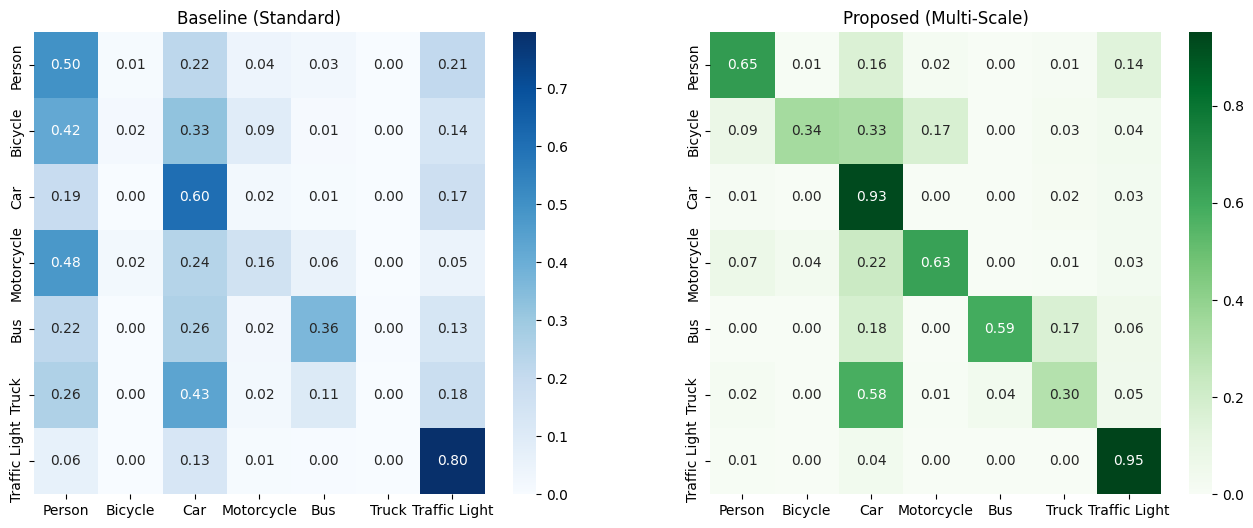

In [16]:
if __name__ == "__main__":
    # 1. Teacher 파인튜닝 (KITTI 적응)
    teacher_weight = finetune_teacher(epochs=2)

    # 2. Baseline 학습 (Concat X)
    train_student_distill(StudentBaseline, "student_baseline", teacher_weight, epochs=3)

    # 3. Proposed 학습 (Multi-Scale)
    train_student_distill(StudentTinyConcat, "student_concat", teacher_weight, epochs=3)

    # 4. 비교 평가
    print("\n" + "="*50 + "\n🔎 최종 비교 결과\n" + "="*50)
    yt_base, yp_base = evaluate_model(StudentBaseline, "student_baseline.pth", "Baseline")
    yt_prop, yp_prop = evaluate_model(StudentTinyConcat, "student_concat.pth", "Proposed")

    # 5. 시각화
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(confusion_matrix(yt_base, yp_base, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=UNIFIED_CLASSES, yticklabels=UNIFIED_CLASSES, ax=ax[0])
    ax[0].set_title("Baseline (Standard)")

    sns.heatmap(confusion_matrix(yt_prop, yp_prop, normalize='true'), annot=True, fmt='.2f', cmap='Greens',
                xticklabels=UNIFIED_CLASSES, yticklabels=UNIFIED_CLASSES, ax=ax[1])
    ax[1].set_title("Proposed (Multi-Scale)")
    plt.show()


👨‍🏫 Teacher (OpenCLIP) 성능 평가 중... [teacher_full_finetuned.pth]
⚡ 파인튜닝된 가중치를 로드합니다.


100%|██████████| 47/47 [02:10<00:00,  2.77s/it]



[Result: Teacher (Fine-tuned)]
               precision    recall  f1-score   support

       Person       0.93      0.74      0.82     10993
      Bicycle       0.31      0.47      0.38       316
          Car       0.66      0.20      0.31      1932
   Motorcycle       0.46      0.65      0.54       371
          Bus       0.24      0.81      0.37       285
        Truck       0.69      0.28      0.40       415
Traffic Light       0.16      0.88      0.27       633

     accuracy                           0.65     14945
    macro avg       0.49      0.57      0.44     14945
 weighted avg       0.82      0.65      0.70     14945



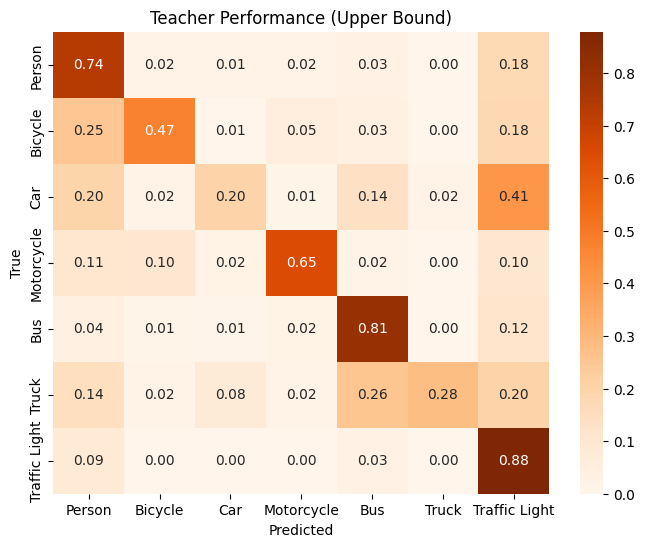

In [17]:
def evaluate_teacher_performance(weight_path):
    print(f"\n👨‍🏫 Teacher (OpenCLIP) 성능 평가 중... [{weight_path}]")

    # 1. 모델 로드
    model, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    if os.path.exists(weight_path):
        print("⚡ 파인튜닝된 가중치를 로드합니다.")
        model.load_state_dict(torch.load(weight_path))
    else:
        print("⚠️ 파인튜닝 파일이 없습니다. Pretrained 가중치로 평가합니다.")

    model = model.to(DEVICE).eval()

    # 2. 텍스트 임베딩 (정답지)
    text_tokens = open_clip.tokenize(TEXT_PROMPTS).to(DEVICE)
    with torch.no_grad():
        text_feats = F.normalize(model.encode_text(text_tokens), dim=-1)

    # 3. 데이터 로더 (기존과 동일)
    val_ds = CocoValWrapper("val2017", "annotations/instances_val2017.json")
    val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            if batch is None: continue
            img, box, lbl = batch
            img = img.to(DEVICE)

            # [핵심] Teacher는 ROI Align 기능이 없으므로,
            # 원본 이미지에서 BBox 영역을 224x224로 잘라내서(Crop & Resize) 입력으로 줍니다.
            # roi_align을 이미지 자체에 적용하면 Crop 효과가 납니다.
            r_box, r_lbl = prepare_roi(box, lbl, DEVICE)
            if r_box is None: continue

            # 입력 이미지(224x224)에서 객체 부분만 224x224로 추출
            # (Student는 Feature Map에서 뽑지만, Teacher는 Raw Image를 봐야 함)
            object_crops = roi_align(img, r_box, output_size=(224, 224), spatial_scale=1.0, aligned=True)

            # Teacher 예측
            img_feats = F.normalize(model.encode_image(object_crops), dim=-1)
            preds = (img_feats @ text_feats.T).argmax(dim=-1)

            y_true.extend(r_lbl.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n[Result: Teacher (Fine-tuned)]")
    print(classification_report(y_true, y_pred, target_names=UNIFIED_CLASSES))

    # 그래프 그리기
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Oranges', xticklabels=UNIFIED_CLASSES, yticklabels=UNIFIED_CLASSES)
    plt.title("Teacher Performance (Upper Bound)")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.show()

if __name__ == "__main__":
    # 아까 저장한 Teacher 가중치 파일 이름
    teacher_file = "teacher_full_finetuned.pth"
    evaluate_teacher_performance(teacher_file)

✅ VQA 데이터 파일 준비 완료.
📂 VQA 파싱 중... (잠시만 기다려주세요)
✅ 매칭된 데이터: 26333개 (전체 평가)

🧠 [Real VQA Comparison] 총 26333개 데이터 전수 평가 시작...


100%|██████████| 823/823 [06:25<00:00,  2.14it/s]
/tmp/ipython-input-1947697631.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")



⏱️ 평가 소요 시간: 6.4분

🏆 [최종 VQA 정확도 비교 - 전수 조사]
      Model  Accuracy (%)
0  Baseline     11.001405
1  Proposed     16.222990
2   Teacher     27.387688


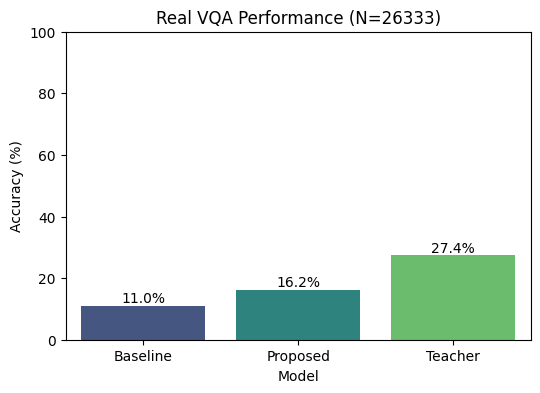

In [20]:
# ==========================================
# 8. Real VQA v2.0 통합 비교 평가 (Full Scale)
# ==========================================
import json
import random
import pandas as pd
from collections import Counter
import time

# VQA 데이터 준비 함수
def prepare_real_coco_vqa():
    if not os.path.exists("v2_OpenEnded_mscoco_val2014_questions.json"):
        print("⬇️ Real VQA v2.0 데이터 다운로드 중...")
        os.system("wget -q https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip")
        os.system("unzip -q v2_Questions_Val_mscoco.zip")
        os.system("wget -q https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip")
        os.system("unzip -q v2_Annotations_Val_mscoco.zip")
    print("✅ VQA 데이터 파일 준비 완료.")

# VQA 데이터셋 래퍼
class RealVQAWrapper(Dataset):
    def __init__(self, img_dir, quest_file, ann_file, transform=None):
        self.img_dir = img_dir; self.transform = transform

        print("📂 VQA 파싱 중... (잠시만 기다려주세요)")
        with open(quest_file, 'r') as f: qs = json.load(f)['questions']
        with open(ann_file, 'r') as f: anns = json.load(f)['annotations']

        self.qid_to_ann = {a['question_id']: a for a in anns}
        self.questions = qs

        self.valid_data = []
        # 파일 존재 여부 확인 (속도를 위해 일부만 체크하지 않고 전체 리스트 생성)
        # COCO Val2017에 있는 이미지만 필터링
        existing_files = set(os.listdir(img_dir))

        for q in self.questions:
            img_id = q['image_id']
            fname = f"{img_id:012d}.jpg"
            if fname in existing_files:
                self.valid_data.append((fname, q))

        print(f"✅ 매칭된 데이터: {len(self.valid_data)}개 (전체 평가)")

    def __len__(self): return len(self.valid_data)

    def __getitem__(self, idx):
        fname, q_data = self.valid_data[idx]
        try: img = Image.open(os.path.join(self.img_dir, fname)).convert('RGB')
        except: return None

        question = q_data['question']
        ann = self.qid_to_ann[q_data['question_id']]
        answers = [a['answer'] for a in ann['answers']]
        most_common_answer = Counter(answers).most_common(1)[0][0]

        # 보기 생성
        fake_answers = ["yes", "no", "1", "2", "white", "red", "blue", "kitchen", "outside", "man", "woman", "car", "truck"]
        options = [most_common_answer]
        while len(options) < 4:
            opt = random.choice(fake_answers)
            if opt not in options: options.append(opt)
        random.shuffle(options)

        if self.transform: img = self.transform(img)
        return img, question, most_common_answer, options

# 배치를 위한 커스텀 Collate 함수
def vqa_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch: return None
    imgs, questions, answers, options_list = zip(*batch)
    imgs = torch.stack(imgs)
    return imgs, questions, answers, options_list

# -----------------------------------------------------------
# ★ 핵심: 세 모델 동시 평가 함수 (배치 처리로 속도 UP)
# -----------------------------------------------------------
def run_comparison_vqa(baseline_path, proposed_path, teacher_path):
    prepare_real_coco_vqa()

    # 1. 모델 준비
    baseline = StudentBaseline(out_dim=640).to(DEVICE)
    if os.path.exists(baseline_path): baseline.load_state_dict(torch.load(baseline_path))
    baseline.eval()

    proposed = StudentTinyConcat(out_dim=640).to(DEVICE)
    if os.path.exists(proposed_path): proposed.load_state_dict(torch.load(proposed_path))
    proposed.eval()

    teacher_v, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    if os.path.exists(teacher_path): teacher_v.load_state_dict(torch.load(teacher_path))
    teacher_v = teacher_v.to(DEVICE).eval()

    # 2. 데이터 로더 (전체 데이터, 배치 사이즈 32)
    eval_transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(MEAN, STD)])
    vqa_ds = RealVQAWrapper("val2017", "v2_OpenEnded_mscoco_val2014_questions.json", "v2_mscoco_val2014_annotations.json", transform=eval_transform)

    # 전체 데이터 사용 (Shuffle X)
    loader = DataLoader(vqa_ds, batch_size=32, shuffle=False, num_workers=2, collate_fn=vqa_collate_fn)

    print(f"\n🧠 [Real VQA Comparison] 총 {len(vqa_ds)}개 데이터 전수 평가 시작...")

    scores = {"Baseline": 0, "Proposed": 0, "Teacher": 0}
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (imgs, questions, answers, options_batch) in enumerate(tqdm(loader)):
            imgs = imgs.to(DEVICE)

            # --- Vision Encoding (배치 단위로 한 번에 처리 -> 속도 향상) ---
            # 1. Baseline Features
            feat_b_batch = baseline.forward_features(imgs)

            # 2. Proposed Features
            feat_p_batch = proposed.forward_features(imgs)

            # 3. Teacher Embeddings
            emb_t_batch = F.normalize(teacher_v.encode_image(imgs), dim=-1)

            # --- Text Matching (샘플별로 처리) ---
            # 질문과 보기가 샘플마다 다르므로 텍스트 인코딩은 루프를 돌려야 함
            for i in range(len(imgs)):
                question = questions[i]
                answer = answers[i]
                options = options_batch[i]

                # 텍스트 임베딩
                prompts = [f"Question: {question} Answer: {opt}" for opt in options]
                text_tokens = open_clip.tokenize(prompts).to(DEVICE)
                text_emb = F.normalize(teacher_v.encode_text(text_tokens), dim=-1)

                # (A) Baseline Prediction
                # ROI Align 에러 해결: 개별 샘플의 피처맵을 꺼내서 처리
                feat_b = feat_b_batch[i].unsqueeze(0) # [1, 768, 7, 7]
                full_roi = torch.tensor([[0, 0, 0, 224, 224]]).float().to(DEVICE)
                emb_b = F.normalize(baseline.forward_roi(feat_b, full_roi), dim=-1)
                pred_b = options[(emb_b @ text_emb.T).argmax().item()]
                if pred_b == answer: scores["Baseline"] += 1

                # (B) Proposed Prediction
                feat_p = feat_p_batch[i].unsqueeze(0)
                global_feat = F.adaptive_avg_pool2d(feat_p, (7,7))
                emb_p = F.normalize(proposed.head(global_feat.flatten(1)), dim=-1)
                pred_p = options[(emb_p @ text_emb.T).argmax().item()]
                if pred_p == answer: scores["Proposed"] += 1

                # (C) Teacher Prediction
                emb_t = emb_t_batch[i].unsqueeze(0)
                pred_t = options[(emb_t @ text_emb.T).argmax().item()]
                if pred_t == answer: scores["Teacher"] += 1

                total += 1

    # 최종 결과 출력
    elapsed = time.time() - start_time
    print(f"\n⏱️ 평가 소요 시간: {elapsed/60:.1f}분")

    results = {k: v/total*100 for k, v in scores.items()}
    print("\n🏆 [최종 VQA 정확도 비교 - 전수 조사]")
    df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy (%)"])
    print(df)

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")
    plt.title(f"Real VQA Performance (N={total})")
    plt.ylim(0, 100)
    for index, row in df.iterrows():
        plt.text(index, row["Accuracy (%)"] + 1, f'{row["Accuracy (%)"]:.1f}%', ha='center', color='black')
    plt.show()

if __name__ == "__main__":
    run_comparison_vqa(
        baseline_path="student_baseline.pth",
        proposed_path="student_concat.pth",
        teacher_path="teacher_full_finetuned.pth"
    )

✅ VQA 데이터 준비 완료.
📂 VQA 데이터 분석 및 '교통' 관련 필터링 중...
✅ 전체 VQA 중 '교통' 관련 리얼 질문 2670개 추출 완료!

🏎️ [Traffic VQA Benchmark] 총 2670개 문제 풀이 시작...


  0%|          | 0/84 [00:00<?, ?it/s]

Q: What is the man doing in the street? / Ans: walking
   Preds -> Base: blue, Prop: red, Teach: red
Q: What does the truck on the left sell? / Ans: ice cream
   Preds -> Base: ice cream, Prop: 2, Teach: white
Q: What kind of sign is above the doorway? / Ans: exit
   Preds -> Base: exit, Prop: bus, Teach: green


100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
/tmp/ipython-input-2885454144.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")



⏱️ 소요 시간: 0.6분

🏆 [교통/자율주행 관련 리얼 VQA 성적표]
      Model  Accuracy (%)
0  Baseline     20.299625
1  Proposed     17.078652
2   Teacher     20.749064


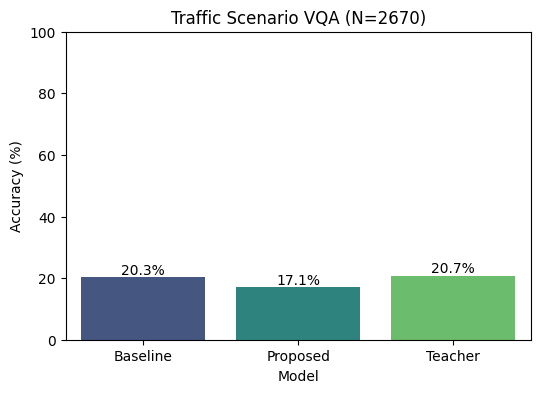

In [22]:
# ==========================================
# 8. Real Traffic VQA (COCO Subset Filtering)
# ==========================================
import json
import pandas as pd
import time

# VQA 데이터 다운로드 (없으면 다운)
def prepare_vqa_data():
    if not os.path.exists("v2_OpenEnded_mscoco_val2014_questions.json"):
        print("⬇️ VQA v2.0 데이터 다운로드 중...")
        os.system("wget -q https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip")
        os.system("unzip -q v2_Questions_Val_mscoco.zip")
        os.system("wget -q https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip")
        os.system("unzip -q v2_Annotations_Val_mscoco.zip")
    print("✅ VQA 데이터 준비 완료.")

class TrafficVQAWrapper(Dataset):
    def __init__(self, img_dir, quest_file, ann_file, transform=None):
        self.img_dir = img_dir; self.transform = transform

        print("📂 VQA 데이터 분석 및 '교통' 관련 필터링 중...")
        with open(quest_file, 'r') as f: qs = json.load(f)['questions']
        with open(ann_file, 'r') as f: anns = json.load(f)['annotations']

        self.qid_to_ann = {a['question_id']: a for a in anns}

        # --- 핵심: 교통 관련 키워드로 필터링 ---
        # 자율주행과 관련된 단어가 포함된 질문만 남깁니다.
        traffic_keywords = [
            "car", "bus", "truck", "vehicle", "traffic", "light", "signal",
            "sign", "road", "street", "lane", "walk", "cross", "stop", "parking"
        ]

        self.valid_data = []
        # COCO Val2017 이미지 파일 목록 확인
        existing_files = set(os.listdir(img_dir))

        for q in qs:
            question_text = q['question'].lower()
            # 1. 키워드가 포함되어 있고
            if any(k in question_text for k in traffic_keywords):
                # 2. 이미지 파일이 실제로 존재해야 함
                img_id = q['image_id']
                fname = f"{img_id:012d}.jpg"
                if fname in existing_files:
                    self.valid_data.append((fname, q))

        print(f"✅ 전체 VQA 중 '교통' 관련 리얼 질문 {len(self.valid_data)}개 추출 완료!")

    def __len__(self): return len(self.valid_data)

    def __getitem__(self, idx):
        fname, q_data = self.valid_data[idx]
        try: img = Image.open(os.path.join(self.img_dir, fname)).convert('RGB')
        except: return None

        question = q_data['question']
        ann = self.qid_to_ann[q_data['question_id']]

        # 정답 (가장 많이 언급된 답)
        answers = [a['answer'] for a in ann['answers']]
        most_common_answer = Counter(answers).most_common(1)[0][0]

        # 보기 생성 (헷갈리는 보기 추가)
        fake_answers = ["yes", "no", "1", "2", "3", "red", "green", "white", "blue", "car", "truck", "bus", "sign"]
        options = [most_common_answer]
        while len(options) < 4:
            opt = random.choice(fake_answers)
            if opt not in options: options.append(opt)
        random.shuffle(options)

        if self.transform: img = self.transform(img)
        return img, question, most_common_answer, options

def vqa_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch: return None
    imgs, qs, ans, opts = zip(*batch)
    return torch.stack(imgs), qs, ans, opts

# -----------------------------------------------------------
# 3개 모델 동시 평가 실행
# -----------------------------------------------------------
def run_traffic_vqa_benchmark(baseline_path, proposed_path, teacher_path):
    prepare_vqa_data()

    # 모델 준비
    baseline = StudentBaseline(out_dim=640).to(DEVICE)
    if os.path.exists(baseline_path): baseline.load_state_dict(torch.load(baseline_path))
    baseline.eval()

    proposed = StudentTinyConcat(out_dim=640).to(DEVICE)
    if os.path.exists(proposed_path): proposed.load_state_dict(torch.load(proposed_path))
    proposed.eval()

    teacher_v, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    if os.path.exists(teacher_path): teacher_v.load_state_dict(torch.load(teacher_path))
    teacher_v = teacher_v.to(DEVICE).eval()

    # 데이터 로더 (필터링된 Traffic VQA 사용)
    eval_transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(MEAN, STD)])
    # COCO Val2017 폴더 사용
    vqa_ds = TrafficVQAWrapper("val2017", "v2_OpenEnded_mscoco_val2014_questions.json", "v2_mscoco_val2014_annotations.json", transform=eval_transform)
    loader = DataLoader(vqa_ds, batch_size=32, shuffle=False, num_workers=2, collate_fn=vqa_collate_fn)

    print(f"\n🏎️ [Traffic VQA Benchmark] 총 {len(vqa_ds)}개 문제 풀이 시작...")

    scores = {"Baseline": 0, "Proposed": 0, "Teacher": 0}
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for imgs, questions, answers, options_batch in tqdm(loader):
            imgs = imgs.to(DEVICE)

            # Feature Extraction
            feat_b = baseline.forward_features(imgs)
            feat_p = proposed.forward_features(imgs)
            emb_t_batch = F.normalize(teacher_v.encode_image(imgs), dim=-1)

            for i in range(len(imgs)):
                question = questions[i]; answer = answers[i]; options = options_batch[i]

                prompts = [f"Question: {question} Answer: {opt}" for opt in options]
                text_toks = open_clip.tokenize(prompts).to(DEVICE)
                text_emb = F.normalize(teacher_v.encode_text(text_toks), dim=-1)

                # Baseline (Full ROI)
                full_roi = torch.tensor([[0, 0, 0, 224, 224]]).float().to(DEVICE)
                emb_b = F.normalize(baseline.forward_roi(feat_b[i].unsqueeze(0), full_roi), dim=-1)
                pred_b = options[(emb_b @ text_emb.T).argmax().item()]
                if pred_b == answer: scores["Baseline"] += 1

                # Proposed (Global Pool)
                g_feat = F.adaptive_avg_pool2d(feat_p[i].unsqueeze(0), (7,7))
                emb_p = F.normalize(proposed.head(g_feat.flatten(1)), dim=-1)
                pred_p = options[(emb_p @ text_emb.T).argmax().item()]
                if pred_p == answer: scores["Proposed"] += 1

                # Teacher
                pred_t = options[(emb_t_batch[i].unsqueeze(0) @ text_emb.T).argmax().item()]
                if pred_t == answer: scores["Teacher"] += 1

                total += 1

                # 샘플 출력 (처음 3개만)
                if total <= 3:
                    print(f"Q: {question} / Ans: {answer}")
                    print(f"   Preds -> Base: {pred_b}, Prop: {pred_p}, Teach: {pred_t}")

    # 결과
    elapsed = time.time() - start_time
    results = {k: v/total*100 for k, v in scores.items()}
    print(f"\n⏱️ 소요 시간: {elapsed/60:.1f}분")
    print("\n🏆 [교통/자율주행 관련 리얼 VQA 성적표]")
    df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy (%)"])
    print(df)

    # 그래프
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")
    plt.title(f"Traffic Scenario VQA (N={total})")
    plt.ylim(0, 100)
    for index, row in df.iterrows():
        plt.text(index, row["Accuracy (%)"] + 1, f'{row["Accuracy (%)"]:.1f}%', ha='center', color='black')
    plt.show()

if __name__ == "__main__":
    run_traffic_vqa_benchmark(
        "student_baseline.pth",
        "student_concat.pth",
        "teacher_full_finetuned.pth"
    )

📊 데이터 준비 중 (Top-20 Answers)...
✅ 최종 데이터: Train 985 / Val 247

🥊 [Teacher] 선수 입장 및 어댑터 학습 시작...


   👉 Teacher Best Val Accuracy: 46.96%

🥊 [Baseline] 선수 입장 및 어댑터 학습 시작...


   👉 Baseline Best Val Accuracy: 47.77%

🥊 [Proposed] 선수 입장 및 어댑터 학습 시작...


   👉 Proposed Best Val Accuracy: 47.77%

🏆 [Final Championship Result]
      Model   Accuracy
0   Teacher  46.963563
1  Baseline  47.773279
2  Proposed  47.773279


/tmp/ipython-input-1512309746.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Accuracy", data=df, palette="viridis")


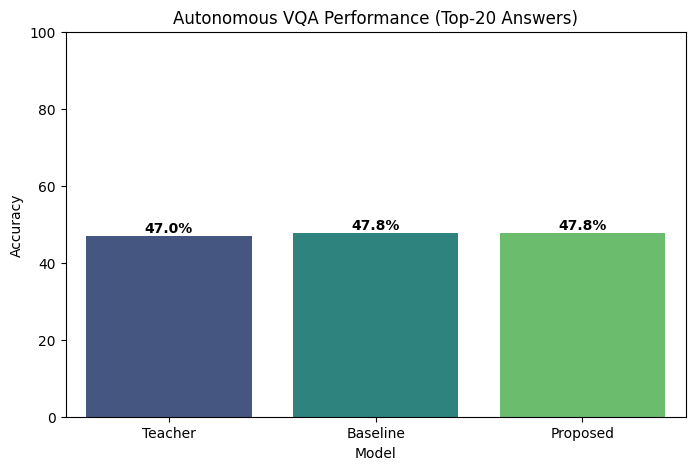

In [28]:
# ==========================================
# 13. Final VQA Championship: Teacher vs Baseline vs Proposed
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import open_clip
import timm
import json
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# -----------------------------------------------------------
# 1. 모델 정의 (Visual Backbones)
# -----------------------------------------------------------

# (A) Baseline: 마지막 층만 사용
class StudentBaseline(nn.Module):
    def __init__(self, out_dim=640):
        super().__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, features_only=True, out_indices=(3,))
        self.head = nn.Sequential(nn.LayerNorm(768), nn.Linear(768, 1024), nn.GELU(), nn.Linear(1024, out_dim))
    def forward(self, x):
        feat = self.backbone(x)[0] # [B, 768, 7, 7]
        pooled = F.adaptive_avg_pool2d(feat, (1,1)).flatten(1)
        return self.head(pooled)

# (B) Proposed: Multi-scale (우리의 주인공)
class StudentTinyConcat(nn.Module):
    def __init__(self, out_dim=640):
        super().__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, features_only=True, out_indices=(1, 2, 3))
        self.fusion = nn.Sequential(nn.Conv2d(1344, 256, 1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.head = nn.Sequential(nn.Flatten(), nn.LayerNorm(256*7*7), nn.Linear(256*7*7, 1024), nn.GELU(), nn.Linear(1024, out_dim))
    def forward(self, x):
        c2, c3, c4 = self.backbone(x)
        h, w = c2.shape[-2:]
        c3 = F.interpolate(c3, size=(h, w), mode='bilinear'); c4 = F.interpolate(c4, size=(h, w), mode='bilinear')
        feat = self.fusion(torch.cat([c2, c3, c4], 1))
        pooled = F.adaptive_avg_pool2d(feat, (7,7)) # VQA를 위해 공간 정보 유지 후 풀링
        return self.head(pooled.flatten(1))

# (C) VQA Adapter (공통 뇌)
class VQAAdapter(nn.Module):
    def __init__(self, input_dim, num_answers):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, num_answers)
        )
    def forward(self, img_emb, txt_emb):
        combined = torch.cat([img_emb, txt_emb], dim=1)
        return self.fusion(combined)

# -----------------------------------------------------------
# 2. 데이터셋 (Top-20 핵심 정답만!)
# -----------------------------------------------------------
TARGET_ANSWERS = [
    "yes", "no", "car", "truck", "bus", "person", "bike", "light", "sign", "stop",
    "red", "green", "yellow", "white", "black", "blue", "1", "2", "3", "many"
]

class TrafficVQADataset(Dataset):
    def __init__(self, data, img_dir, transform):
        self.data = data; self.img_dir = img_dir; self.transform = transform
        self.answer_to_idx = {ans: i for i, ans in enumerate(TARGET_ANSWERS)}
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        fname, q, ans_str = self.data[idx]
        try: img = Image.open(os.path.join(self.img_dir, fname)).convert('RGB')
        except: return None
        if self.transform: img = self.transform(img)
        ans_idx = self.answer_to_idx.get(ans_str, -1)
        return img, q, ans_idx

# -----------------------------------------------------------
# 3. 3파전 벤치마크 실행 함수
# -----------------------------------------------------------
def run_championship():
    print("📊 데이터 준비 중 (Top-20 Answers)...")
    # 데이터 로드 (이전 코드 활용)
    with open("v2_OpenEnded_mscoco_val2014_questions.json") as f: qs = json.load(f)['questions']
    with open("v2_mscoco_val2014_annotations.json") as f: anns = json.load(f)['annotations']
    qid_to_ann = {a['question_id']: a for a in anns}

    # Traffic 필터링
    traffic_keywords = ["car", "bus", "truck", "vehicle", "traffic", "light", "signal", "sign", "road", "street"]
    existing = set(os.listdir("val2017"))
    full_data = []
    for q in qs:
        if any(k in q['question'].lower() for k in traffic_keywords):
            fname = f"{q['image_id']:012d}.jpg"
            if fname in existing:
                ans = Counter([a['answer'] for a in qid_to_ann[q['question_id']]['answers']]).most_common(1)[0][0]
                if ans in TARGET_ANSWERS: # 우리가 정한 20개 답에 포함되는 것만
                    full_data.append((fname, q['question'], ans))

    train_list, val_list = train_test_split(full_data, test_size=0.2, random_state=42)
    print(f"✅ 최종 데이터: Train {len(train_list)} / Val {len(val_list)}")

    transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(MEAN, STD)])
    train_loader = DataLoader(TrafficVQADataset(train_list, "val2017", transform), batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(TrafficVQADataset(val_list, "val2017", transform), batch_size=32, shuffle=False)

    # 텍스트 인코더 (공통)
    text_encoder, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    text_encoder = text_encoder.to(DEVICE).eval()

    # 결과 저장소
    results = {}

    # --- 3개 모델 순회 ---
    models = ["Teacher", "Baseline", "Proposed"]

    for name in models:
        print(f"\n🥊 [{name}] 선수 입장 및 어댑터 학습 시작...")

        # 1. Backbone 로드 (Freeze)
        if name == "Teacher":
            vision_model, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
            if os.path.exists("teacher_full_finetuned.pth"): vision_model.load_state_dict(torch.load("teacher_full_finetuned.pth"))
            vision_model = vision_model.to(DEVICE).eval()
        elif name == "Baseline":
            vision_model = StudentBaseline(out_dim=640).to(DEVICE).eval()
            if os.path.exists("student_baseline.pth"): vision_model.load_state_dict(torch.load("student_baseline.pth"))
        elif name == "Proposed":
            vision_model = StudentTinyConcat(out_dim=640).to(DEVICE).eval()
            if os.path.exists("student_concat.pth"): vision_model.load_state_dict(torch.load("student_concat.pth"))

        for p in vision_model.parameters(): p.requires_grad = False

        # 2. Adapter 초기화 (Vision 640 + Text 640 -> Answer 20)
        adapter = VQAAdapter(1280, len(TARGET_ANSWERS)).to(DEVICE)
        optimizer = optim.Adam(adapter.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # 3. 학습 (5 Epoch)
        best_acc = 0
        for ep in range(5):
            adapter.train()
            for imgs, qs, ans_idx in tqdm(train_loader, desc=f"{name} Ep{ep+1}", leave=False):
                imgs, ans_idx = imgs.to(DEVICE), ans_idx.to(DEVICE)
                with torch.no_grad():
                    # CLIP Text
                    txt_emb = text_encoder.encode_text(open_clip.tokenize(qs).to(DEVICE))
                    # Vision Backbone
                    if name == "Teacher": img_emb = vision_model.encode_image(imgs)
                    else: img_emb = vision_model(imgs)

                logits = adapter(F.normalize(img_emb, dim=-1), F.normalize(txt_emb, dim=-1))
                loss = criterion(logits, ans_idx)
                optimizer.zero_grad(); loss.backward(); optimizer.step()

            # 4. 검증
            adapter.eval()
            correct = 0; total = 0
            with torch.no_grad():
                for imgs, qs, ans_idx in val_loader:
                    imgs, ans_idx = imgs.to(DEVICE), ans_idx.to(DEVICE)
                    txt_emb = text_encoder.encode_text(open_clip.tokenize(qs).to(DEVICE))
                    if name == "Teacher": img_emb = vision_model.encode_image(imgs)
                    else: img_emb = vision_model(imgs)

                    logits = adapter(F.normalize(img_emb, dim=-1), F.normalize(txt_emb, dim=-1))
                    preds = logits.argmax(dim=1)
                    correct += (preds == ans_idx).sum().item()
                    total += len(ans_idx)

            acc = correct / total * 100
            if acc > best_acc: best_acc = acc

        print(f"   👉 {name} Best Val Accuracy: {best_acc:.2f}%")
        results[name] = best_acc

    # 최종 그래프
    print("\n🏆 [Final Championship Result]")
    df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
    print(df)
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x="Model", y="Accuracy", data=df, palette="viridis")
    plt.title("Autonomous VQA Performance (Top-20 Answers)")
    plt.ylim(0, 100)
    for i, v in enumerate(df["Accuracy"]):
        ax.text(i, v+1, f"{v:.1f}%", ha='center', fontweight='bold')
    plt.show()

if __name__ == "__main__":
    run_championship()

In [36]:
# ==========================================
# 15. All-in-One: Train Adapter & Analyze (Fix Dimensions)
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import open_clip
import timm
import json
import os
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# 1. 모델 정의 (Visual: 640 dim)
class StudentTinyConcat(nn.Module):
    def __init__(self, out_dim=640):
        super().__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, features_only=True, out_indices=(1, 2, 3))
        self.fusion = nn.Sequential(nn.Conv2d(1344, 256, 1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.head = nn.Sequential(nn.Flatten(), nn.LayerNorm(256*7*7), nn.Linear(256*7*7, 1024), nn.GELU(), nn.Linear(1024, out_dim))
    def forward(self, x):
        c2, c3, c4 = self.backbone(x)
        h, w = c2.shape[-2:]
        c3 = F.interpolate(c3, size=(h, w), mode='bilinear'); c4 = F.interpolate(c4, size=(h, w), mode='bilinear')
        feat = self.fusion(torch.cat([c2, c3, c4], 1))
        pooled = F.adaptive_avg_pool2d(feat, (7,7))
        return self.head(pooled.flatten(1))

# 2. 어댑터 정의 (입력 1280 -> 출력 20)
class VQAAdapter(nn.Module):
    def __init__(self, input_dim, num_answers):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, num_answers)
        )
    def forward(self, img_emb, txt_emb):
        combined = torch.cat([img_emb, txt_emb], dim=1)
        return self.fusion(combined)

# 3. 데이터셋 정의
TARGET_ANSWERS = [
    "yes", "no", "car", "truck", "bus", "person", "bike", "light", "sign", "stop",
    "red", "green", "yellow", "white", "black", "blue", "1", "2", "3", "many"
]

class TrafficVQADataset(Dataset):
    def __init__(self, data, img_dir, transform):
        self.data = data; self.img_dir = img_dir; self.transform = transform
        self.answer_to_idx = {ans: i for i, ans in enumerate(TARGET_ANSWERS)}
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        fname, q, ans_str = self.data[idx]
        try: img = Image.open(os.path.join(self.img_dir, fname)).convert('RGB')
        except: return None
        if self.transform: img = self.transform(img)
        ans_idx = self.answer_to_idx.get(ans_str, -1)
        return img, q, ans_idx

# 4. 메인 실행 로직 (학습 -> 분석)
def train_and_analyze(student_path, epochs=5):
    print("🔄 데이터 및 모델 준비 중...")

    # (A) 데이터 로드
    with open("v2_OpenEnded_mscoco_val2014_questions.json") as f: qs = json.load(f)['questions']
    with open("v2_mscoco_val2014_annotations.json") as f: anns = json.load(f)['annotations']
    qid_to_ann = {a['question_id']: a for a in anns}

    traffic_keywords = ["car", "bus", "truck", "vehicle", "traffic", "light", "signal", "sign", "road", "street"]
    existing = set(os.listdir("val2017"))

    full_data = []
    for q in qs:
        if any(k in q['question'].lower() for k in traffic_keywords):
            fname = f"{q['image_id']:012d}.jpg"
            if fname in existing:
                ans = Counter([a['answer'] for a in qid_to_ann[q['question_id']]['answers']]).most_common(1)[0][0]
                if ans in TARGET_ANSWERS: full_data.append((fname, q['question'], ans))

    train_list, val_list = train_test_split(full_data, test_size=0.2, random_state=42)
    transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(MEAN, STD)])

    train_loader = DataLoader(TrafficVQADataset(train_list, "val2017", transform), batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(TrafficVQADataset(val_list, "val2017", transform), batch_size=32, shuffle=False)

    # (B) 모델 로드
    student = StudentTinyConcat(out_dim=640).to(DEVICE).eval()
    if os.path.exists(student_path): student.load_state_dict(torch.load(student_path))

    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher = teacher.to(DEVICE).eval()

    # (C) 어댑터 초기화 (Vision 640 + Text 640 = 1280 -> Answer 20)
    adapter = VQAAdapter(1280, len(TARGET_ANSWERS)).to(DEVICE)
    optimizer = optim.Adam(adapter.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print(f"\n🚀 어댑터 재학습 시작 (Epochs: {epochs})")
    for ep in range(epochs):
        adapter.train()
        for imgs, qs, ans_idx in tqdm(train_loader, desc=f"Training Ep{ep+1}"):
            imgs, ans_idx = imgs.to(DEVICE), ans_idx.to(DEVICE)
            with torch.no_grad():
                txt_emb = F.normalize(teacher.encode_text(open_clip.tokenize(qs).to(DEVICE)), dim=-1)
                img_emb = F.normalize(student(imgs), dim=-1)

            logits = adapter(img_emb, txt_emb)
            loss = criterion(logits, ans_idx)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    print("\n✅ 학습 완료! 이제 '정답 분포'를 뜯어봅시다.")

    # (D) 정답 분포 분석
    idx_to_ans = {i: ans for i, ans in enumerate(TARGET_ANSWERS)}
    all_preds = []
    all_truths = []

    adapter.eval()
    with torch.no_grad():
        for imgs, qs, ans_idx in tqdm(val_loader, desc="Analyzing Predictions"):
            imgs, ans_idx = imgs.to(DEVICE), ans_idx.to(DEVICE)

            txt_emb = F.normalize(teacher.encode_text(open_clip.tokenize(qs).to(DEVICE)), dim=-1)
            img_emb = F.normalize(student(imgs), dim=-1)

            logits = adapter(img_emb, txt_emb)
            preds = logits.argmax(dim=1)

            for p in preds: all_preds.append(idx_to_ans[p.item()])
            for t in ans_idx: all_truths.append(idx_to_ans[t.item()])

    # 결과 출력
    pred_counts = Counter(all_preds)
    true_counts = Counter(all_truths)

    print("\n📊 [정답 분포 vs 예측 분포]")
    print(f"{'Answer':<10} | {'Actual':<10} | {'Predicted':<10}")
    print("-" * 35)

    # 실제 많이 나온 정답 순서대로 출력
    sorted_keys = sorted(TARGET_ANSWERS, key=lambda x: true_counts[x], reverse=True)

    for ans in sorted_keys:
        if true_counts[ans] > 0: # 실제 정답에 있는 경우만 출력
            print(f"{ans:<10} | {true_counts[ans]:<10} | {pred_counts[ans]:<10}")

    print(f"\n🤖 모델의 최애 답변 Top 3: {pred_counts.most_common(3)}")

    # 정확도 계산
    correct = sum([1 for i in range(len(all_preds)) if all_preds[i] == all_truths[i]])
    acc = correct / len(all_preds) * 100
    print(f"\n🏆 Validation Accuracy: {acc:.2f}%")

# 실행
if __name__ == "__main__":
    train_and_analyze("student_concat.pth", epochs=5)

🔄 데이터 및 모델 준비 중...

🚀 어댑터 재학습 시작 (Epochs: 5)


Training Ep5: 100%|██████████| 31/31 [00:04<00:00,  7.64it/s]



✅ 학습 완료! 이제 '정답 분포'를 뜯어봅시다.


Analyzing Predictions: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]



📊 [정답 분포 vs 예측 분포]
Answer     | Actual     | Predicted 
-----------------------------------
yes        | 81         | 121       
no         | 79         | 48        
3          | 14         | 4         
red        | 13         | 18        
2          | 11         | 6         
1          | 10         | 20        
stop       | 8          | 4         
green      | 7          | 1         
yellow     | 7          | 1         
white      | 5          | 19        
blue       | 5          | 1         
bus        | 2          | 0         
light      | 2          | 0         
black      | 2          | 2         
truck      | 1          | 2         

🤖 모델의 최애 답변 Top 3: [('yes', 121), ('no', 48), ('1', 20)]

🏆 Validation Accuracy: 43.72%



📦 표준 벤치마크 데이터셋 다운로드 중...


100%|██████████| 169M/169M [00:19<00:00, 8.71MB/s]
100%|██████████| 89.0M/89.0M [00:05<00:00, 16.5MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 194kB/s]



⚔️ [Baseline] 평가 시작...
   Embedding 100 class names...


Evaluating CIFAR-100: 100%|██████████| 157/157 [00:13<00:00, 11.85it/s]


   👉 CIFAR-100 Accuracy: 1.14%
   Embedding 43 class names...


Evaluating GTSRB (Signs): 100%|██████████| 198/198 [00:13<00:00, 14.57it/s]


   👉 GTSRB (Signs) Accuracy: 1.62%

⚔️ [Proposed] 평가 시작...
   Embedding 100 class names...


Evaluating CIFAR-100: 100%|██████████| 157/157 [00:11<00:00, 14.00it/s]


   👉 CIFAR-100 Accuracy: 1.71%
   Embedding 43 class names...


Evaluating GTSRB (Signs): 100%|██████████| 198/198 [00:13<00:00, 14.20it/s]


   👉 GTSRB (Signs) Accuracy: 0.78%

🏆 [Standard Benchmark Result]
     Dataset     Model  Accuracy
0  CIFAR-100  Baseline  1.140000
1      GTSRB  Baseline  1.615202
2  CIFAR-100  Proposed  1.710000
3      GTSRB  Proposed  0.783848


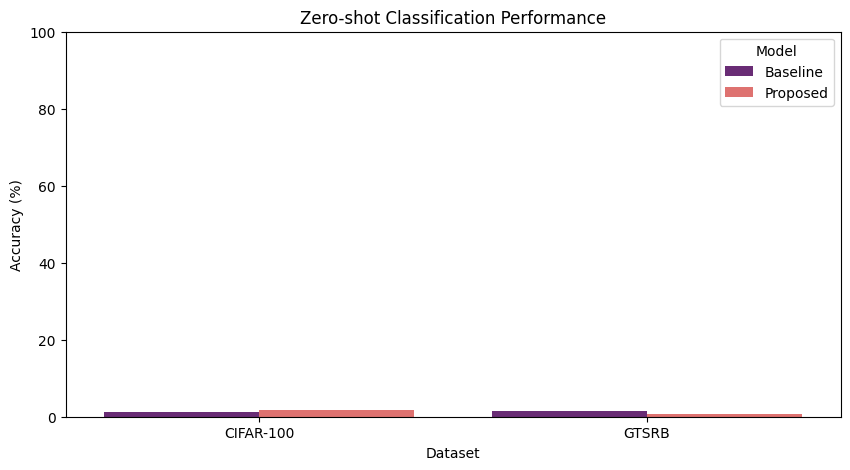

In [37]:
# ==========================================
# 17. Standard Benchmarks: CIFAR-100 & GTSRB
# ==========================================
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

# -------------------------------------------------------
# 1. GTSRB (Traffic Sign) 클래스 정의 (43개)
# -------------------------------------------------------
GTSRB_CLASSES = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

# -------------------------------------------------------
# 2. 평가 함수 (Zero-shot Classification)
# -------------------------------------------------------
def evaluate_zeroshot_dataset(name, model, teacher_text, dataloader, class_names, device):
    model.eval()
    correct = 0
    total = 0

    # 텍스트 프롬프트 임베딩 미리 생성
    print(f"   Embedding {len(class_names)} class names...")
    with torch.no_grad():
        prompts = [f"a photo of a {c}" for c in class_names]
        text_tokens = open_clip.tokenize(prompts).to(device)
        # Teacher의 Text Encoder를 써서 정답지 생성
        text_features = F.normalize(teacher_text.encode_text(text_tokens), dim=-1)

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc=f"Evaluating {name}"):
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Student: 이미지 특징 추출
            # forward_features가 아니라 최종 head까지 통과한 값을 씀 (Zero-shot용)
            # 하지만 Zero-shot은 Feature끼리 비교해야 하므로 Head 전 단계를 쓰거나,
            # 단순히 아까 VQA처럼 Student Feature -> Dot Product -> Text Feature 방식을 씀

            # 여기서는 Student가 'OpenCLIP Feature Space'를 모방했으므로,
            # Student의 Output과 Teacher의 Text Output을 바로 비교합니다.

            # Student Forward (Cell 13 기준: Head 통과 후 640차원)
            img_features = F.normalize(model(imgs), dim=-1)

            # 유사도 계산
            logits = 100.0 * img_features @ text_features.T
            preds = logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    print(f"   👉 {name} Accuracy: {acc:.2f}%")
    return acc

# -------------------------------------------------------
# 3. 메인 실행: CIFAR-100 & GTSRB 다운로드 및 평가
# -------------------------------------------------------
def run_standard_benchmarks():
    print("\n📦 표준 벤치마크 데이터셋 다운로드 중...")

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ])

    # 1. CIFAR-100 (General Object)
    cifar_ds = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    cifar_loader = DataLoader(cifar_ds, batch_size=64, shuffle=False, num_workers=2)
    cifar_classes = cifar_ds.classes

    # 2. GTSRB (Traffic Signs)
    # GTSRB는 다운로드가 좀 걸릴 수 있음 (약 300MB)
    try:
        gtsrb_ds = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform)
        gtsrb_loader = DataLoader(gtsrb_ds, batch_size=64, shuffle=False, num_workers=2)
        # GTSRB는 라벨이 숫자로 나오므로 위에서 정의한 딕셔너리 사용
        gtsrb_class_names = [GTSRB_CLASSES[i] for i in range(43)]
    except Exception as e:
        print(f"⚠️ GTSRB 다운로드 실패 (서버 문제 가능성): {e}")
        gtsrb_loader = None

    # 모델 준비
    models = {
        "Baseline": "student_baseline.pth",
        "Proposed": "student_concat.pth"
    }

    # Teacher (Text Encoder용)
    teacher, _, _ = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k')
    teacher = teacher.to(DEVICE).eval()

    # 결과 저장
    final_scores = {"Dataset": [], "Model": [], "Accuracy": []}

    for model_name, path in models.items():
        print(f"\n⚔️ [{model_name}] 평가 시작...")

        # 모델 로드
        if model_name == "Baseline":
            student = StudentBaseline(out_dim=640).to(DEVICE).eval()
        else:
            student = StudentTinyConcat(out_dim=640).to(DEVICE).eval()

        if os.path.exists(path):
            student.load_state_dict(torch.load(path))
        else:
            print(f"❌ {path} 파일이 없습니다. 스킵합니다.")
            continue

        # CIFAR-100 평가
        acc = evaluate_zeroshot_dataset("CIFAR-100", student, teacher, cifar_loader, cifar_classes, DEVICE)
        final_scores["Dataset"].append("CIFAR-100")
        final_scores["Model"].append(model_name)
        final_scores["Accuracy"].append(acc)

        # GTSRB 평가
        if gtsrb_loader:
            acc = evaluate_zeroshot_dataset("GTSRB (Signs)", student, teacher, gtsrb_loader, gtsrb_class_names, DEVICE)
            final_scores["Dataset"].append("GTSRB")
            final_scores["Model"].append(model_name)
            final_scores["Accuracy"].append(acc)

    # 결과 시각화
    print("\n🏆 [Standard Benchmark Result]")
    df = pd.DataFrame(final_scores)
    print(df)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=df, palette="magma")
    plt.title("Zero-shot Classification Performance")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

if __name__ == "__main__":
    run_standard_benchmarks()